In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime as dt

%matplotlib inline
sns.set()

## Предобработка данных

In [28]:
df = pd.read_csv("dataset_file_storage.csv", sep=";")
df.dropna()
# df["uploadServerUnixTime"] = pd.to_datetime(df["uploadServerUnixTime"]) <- это неправильно работает

df["uploadServerUnixTime"] = df["uploadServerUnixTime"].astype('datetime64[s]')

df["year"] = df["uploadServerUnixTime"].dt.year
df["month"] = df["uploadServerUnixTime"].dt.month
df["day"] = df["uploadServerUnixTime"].dt.day
df["date"] = df["uploadServerUnixTime"].dt.date 
df["weekday"] = df["uploadServerUnixTime"].dt.day_name()  # название дня недели

# удаляем март, потому что там мало данных
df = df[~((df["year"] == 2020) & (df["month"] == 3))].copy()

df.head(5)

,ProjectID,UserID,uploadServerUnixTime,CompanyID,FileSize,TypeDocs,year,month,day,date,weekday
0,753919,27549,2020-02-21 08:07:23,753918,732686,6.Юридические документы,2020,2,21,2020-02-21,Friday
1,726628,26990,2020-02-20 16:33:36,726615,2484373,8.Другие документы,2020,2,20,2020-02-20,Thursday
2,705607,26912,2019-10-22 08:14:37,703124,22,1.Основные документы,2019,10,22,2019-10-22,Tuesday
3,705605,26912,2019-10-14 10:23:41,703124,4,1.Основные документы,2019,10,14,2019-10-14,Monday
4,705605,26912,2019-10-11 13:06:50,703124,1030735,1.Основные документы,2019,10,11,2019-10-11,Friday


In [31]:
# как дропать ненужные столбцы есчо -> .drop(columns=["hour", "minute", "second"])

grp = (df.groupby(["date", "year", "month", "day"])
       .sum(numeric_only=True)
       .rename(columns={"FileSize":"bytes_per_day"})
       .reset_index()
      )
grp.sort_values(by=["date", "year", "month", "day"], axis=0, ascending=True, inplace=True)

# Накопительная сумма
grp["cum_bytes"] = grp["bytes_per_day"].cumsum()
grp

,date,year,month,day,ProjectID,UserID,CompanyID,bytes_per_day,cum_bytes
0,2019-10-10,2019,10,10,705605,26912,703124,239262494,239262494
1,2019-10-11,2019,10,11,2116815,80736,2109372,2061474,241323968
2,2019-10-14,2019,10,14,2116815,80736,2109372,12,241323980
3,2019-10-15,2019,10,15,1411214,53824,1406248,2267003,243590983
4,2019-10-16,2019,10,16,705605,26912,703124,4,243590987
...,...,...,...,...,...,...,...,...,...
82,2020-02-21,2020,2,21,9693662,356463,9686387,696222039,25253628434
83,2020-02-25,2020,2,25,10490982,385113,10408071,79350128,25332978562
84,2020-02-26,2020,2,26,23158837,849422,23121263,119462503,25452441065
85,2020-02-27,2020,2,27,28668377,1046630,28668339,33374132,25485815197


## Задание 1.1

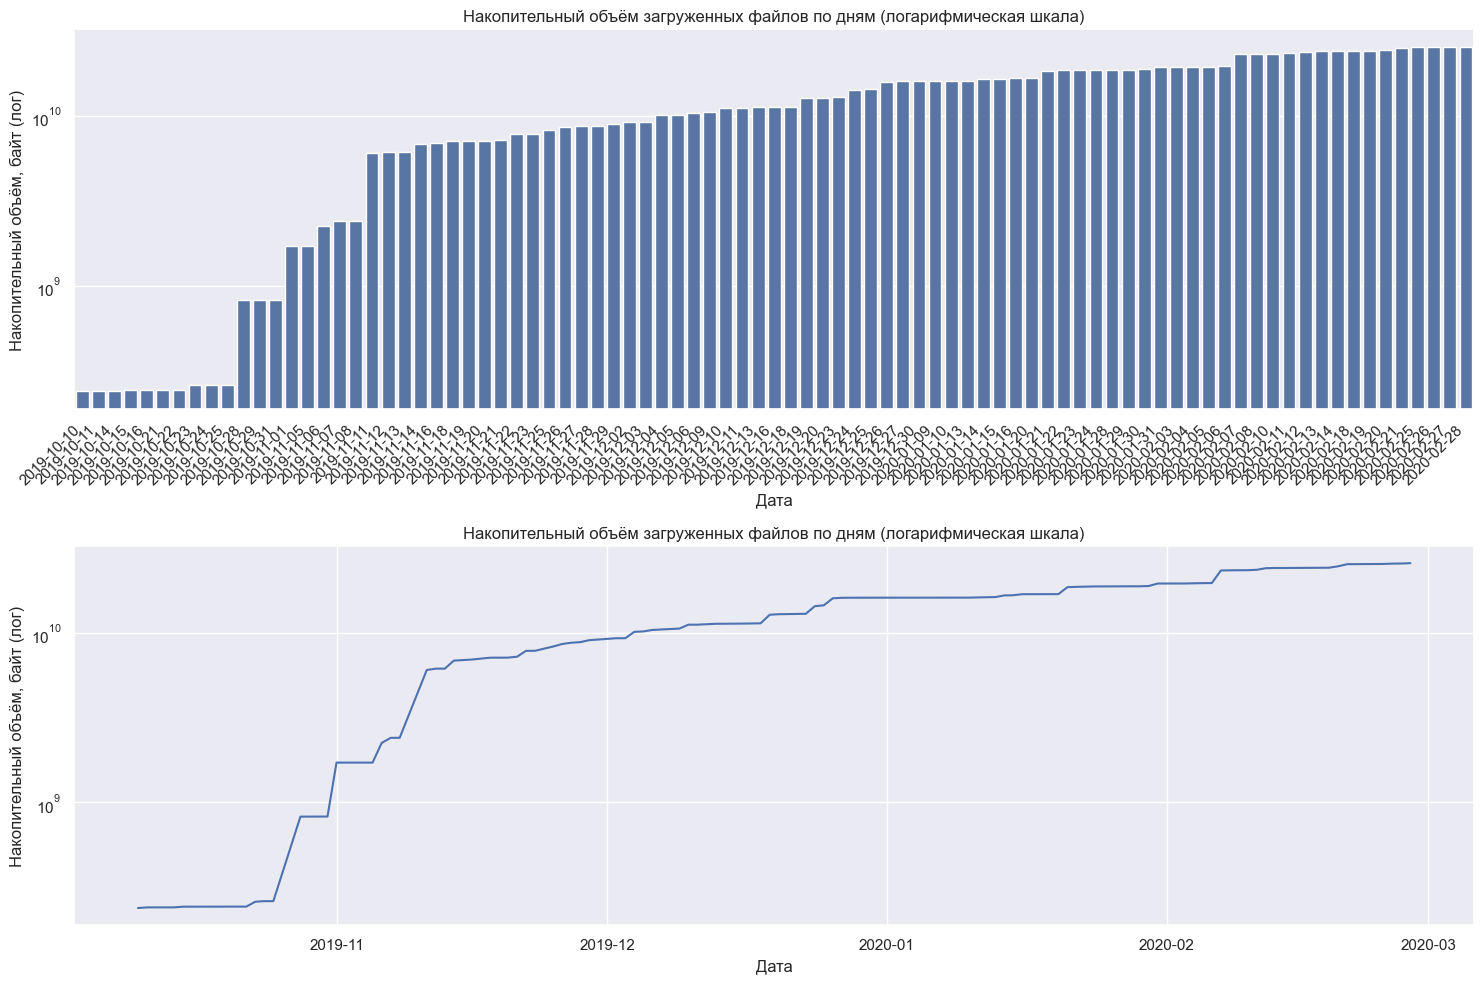

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

sns.barplot(x="date", y="cum_bytes", data=grp, ax=ax[0])
sns.lineplot(x="date", y="cum_bytes", data=grp, ax=ax[1])

ax[0].set_yscale("log")
ax[0].set_title("Накопительный объём загруженных файлов по дням (логарифмическая шкала)")
ax[0].set_xlabel("Дата")
ax[0].set_ylabel("Накопительный объём, байт (лог)")

ax[1].set_yscale("log")
ax[1].set_title("Накопительный объём загруженных файлов по дням (логарифмическая шкала)")
ax[1].set_xlabel("Дата")
ax[1].set_ylabel("Накопительный объём, байт (лог)")

# добавляем наклон, чтобы ничо не слипалось на первом графике
for label in ax[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right") # выравнивание по правому краю

plt.tight_layout()


## Задание 1.2

In [111]:
# Группируем по месяцам и вычисляем накопленную сумму

monthly = (
    df.groupby(["year", "month"], as_index=False)["FileSize"]
    .sum()
    .rename(columns={"FileSize":"bytes_per_day"})
    .sort_values(by=["year", "month"])
)

monthly["cum_bytes"] = monthly["bytes_per_day"].cumsum()

# Преобразуем в даты в индекс (берём 1-е число каждого месяца)
monthly["month_start"] = pd.to_datetime(dict(year=monthly["year"], month=monthly["month"], day=1))
monthly = monthly.set_index("month_start")

monthly

,year,month,bytes_per_day,cum_bytes
month_start,,,,
2019-10-01,2019,10,826412626,826412626
2019-11-01,2019,11,8192058931,9018471557
2019-12-01,2019,12,7022650581,16041122138
2020-01-01,2020,1,3391116262,19432238400
2020-02-01,2020,2,6180915712,25613154112


In [121]:
# Создаем тренировочный набор: до февраля 2020 (включительно)

train = monthly.loc[:"2020-02-01"].copy()
train

,year,month,bytes_per_day,cum_bytes
month_start,,,,
2019-10-01,2019,10,826412626,826412626
2019-11-01,2019,11,8192058931,9018471557
2019-12-01,2019,12,7022650581,16041122138
2020-01-01,2020,1,3391116262,19432238400
2020-02-01,2020,2,6180915712,25613154112


In [113]:
# Подготовим календарь до конца 2020 года

start = pd.Timestamp(train.index[0])
end = pd.Timestamp("2020-12-01", tz=None)
full_index = pd.period_range(start=start, end=end, freq="M").to_timestamp("M") - pd.offsets.MonthEnd(1) + pd.offsets.MonthBegin(1)
print(full_index)

# full_index = pd.DatetimeIndex(pd.Timestamp(d.year, d.month, 1) for d in full_index) <- другой способ получить то же самое

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq=None)


In [118]:
# Данные по накопленной сумме на доступном участке

actual_cumsum = train["cum_bytes"].reindex(full_index)
actual_cumsum

2019-10-01    8.264126e+08
2019-11-01    9.018472e+09
2019-12-01    1.604112e+10
2020-01-01    1.943224e+10
2020-02-01    2.561315e+10
2020-03-01             NaN
2020-04-01             NaN
2020-05-01             NaN
2020-06-01             NaN
2020-07-01             NaN
2020-08-01             NaN
2020-09-01             NaN
2020-10-01             NaN
2020-11-01             NaN
2020-12-01             NaN
Name: cum_bytes, dtype: float64

In [199]:
# Прогноз 1: среднемесячный прирост

avg_growth = monthly["cum_bytes"].diff().mean()
simple_forecast = train[["cum_bytes"]].reindex(full_index)

for i in range(len(train), len(full_index)):
    simple_forecast.iloc[i, 0] = simple_forecast.iloc[i - 1, 0] + avg_growth

simple_forecast.iloc[:len(train) - 1] = None
# print(simple_forecast)

In [198]:
# Прогноз 2: LinearRegression по периоду
train["period"] = np.arange(len(train))
X = train[["period"]].values # Делаем так потому, что LinearRegression.fit() требует двумерный массив признаков X. Даже если признак всего один, размер должен быть (n, 1), а не (n,).
y = train["cum_bytes"].values
model = LinearRegression()
model.fit(X, y)

lr_forecast = pd.Series(index=full_index, dtype="float64")
pred_vals = model.predict(np.arange(len(train), len(full_index))[:, None])
# print(pred_vals)
lr_forecast.iloc[len(train):] = pred_vals
lr_forecast.iloc[len(train) - 1] = train.loc["2020-02-01", "cum_bytes"]

# print(lr_forecast)


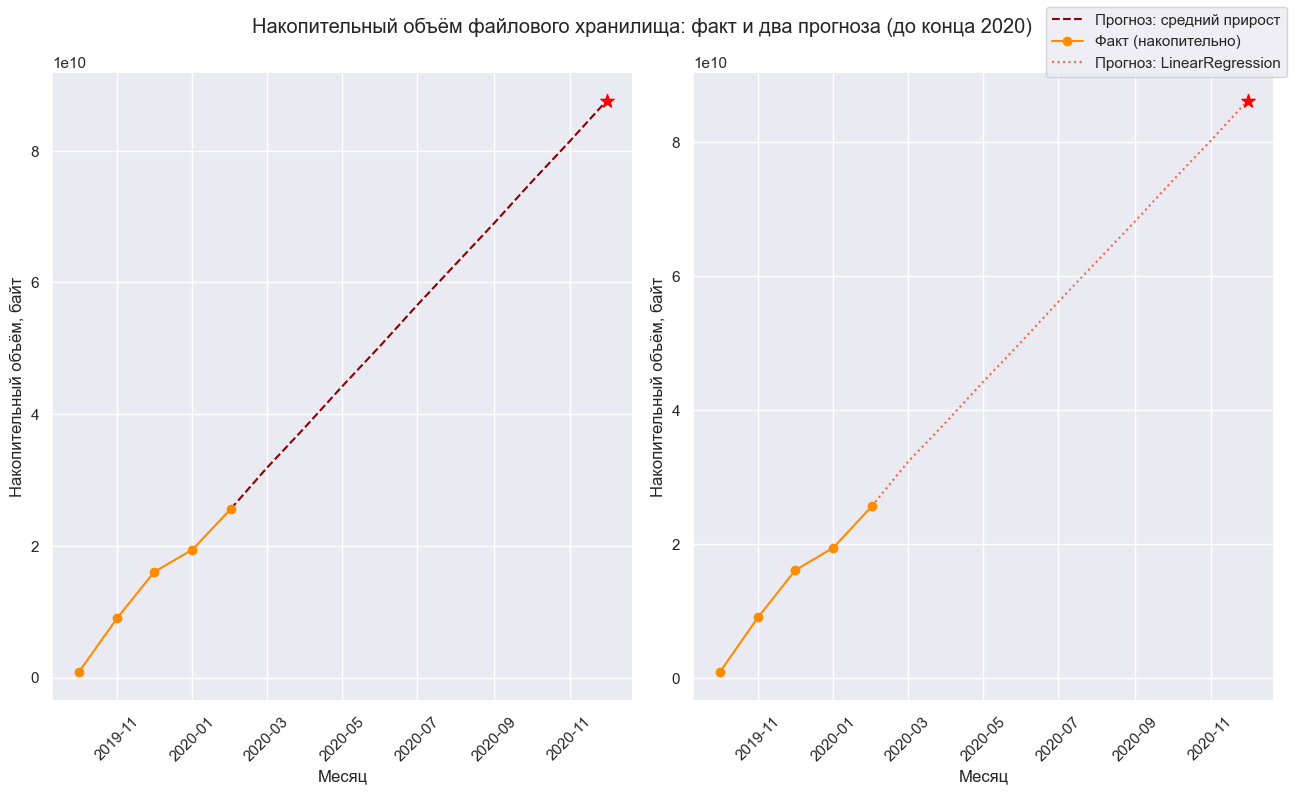

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8))

axes[0].plot(simple_forecast.index, simple_forecast.values, linestyle="--", color="#8B0000", label="Прогноз: средний прирост")
axes[1].plot(lr_forecast.index, lr_forecast.values, linestyle=":", color="#FF6347", label="Прогноз: LinearRegression")
axes[0].plot(actual_cumsum.index, actual_cumsum.values, marker="o", color="#FF8C00", label="Факт (накопительно)")
axes[1].plot(actual_cumsum.index, actual_cumsum.values, marker="o", color="#FF8C00")

axes[0].scatter(simple_forecast.index[-1], simple_forecast.values[-1], marker="*", color="#FF0000", zorder=5, s=100)
axes[1].scatter(lr_forecast.index[-1], lr_forecast.values[-1], marker="*", color="#FF0000", zorder=5, s=100)

axes[0].set_xlabel("Месяц")
axes[0].set_ylabel("Накопительный объём, байт")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, which="both", axis="y")

axes[1].set_xlabel("Месяц")
axes[1].set_ylabel("Накопительный объём, байт")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, which="both", axis="y")

fig.suptitle("Накопительный объём файлового хранилища: факт и два прогноза (до конца 2020)")
fig.legend()
fig.tight_layout()

In [204]:
df["dow"]  = df["uploadServerUnixTime"].dt.dayofweek
df["hour"] = df["uploadServerUnixTime"].dt.hour
df.head()

,ProjectID,UserID,uploadServerUnixTime,CompanyID,FileSize,TypeDocs,year,month,day,date,weekday,dow,hour
0,753919,27549,2020-02-21 08:07:23,753918,732686,6.Юридические документы,2020,2,21,2020-02-21,Friday,4,8
1,726628,26990,2020-02-20 16:33:36,726615,2484373,8.Другие документы,2020,2,20,2020-02-20,Thursday,3,16
2,705607,26912,2019-10-22 08:14:37,703124,22,1.Основные документы,2019,10,22,2019-10-22,Tuesday,1,8
3,705605,26912,2019-10-14 10:23:41,703124,4,1.Основные документы,2019,10,14,2019-10-14,Monday,0,10
4,705605,26912,2019-10-11 13:06:50,703124,1030735,1.Основные документы,2019,10,11,2019-10-11,Friday,4,13


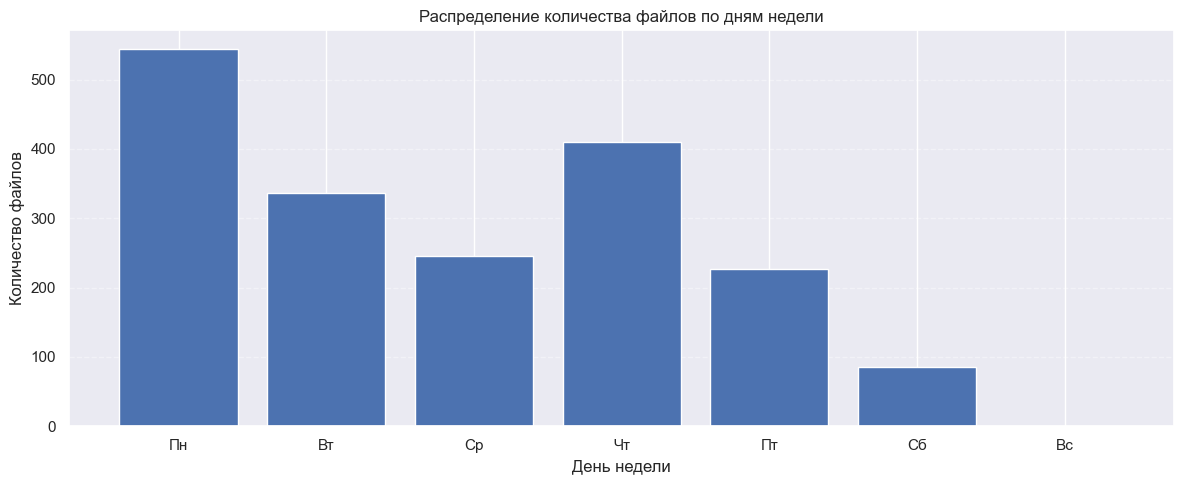

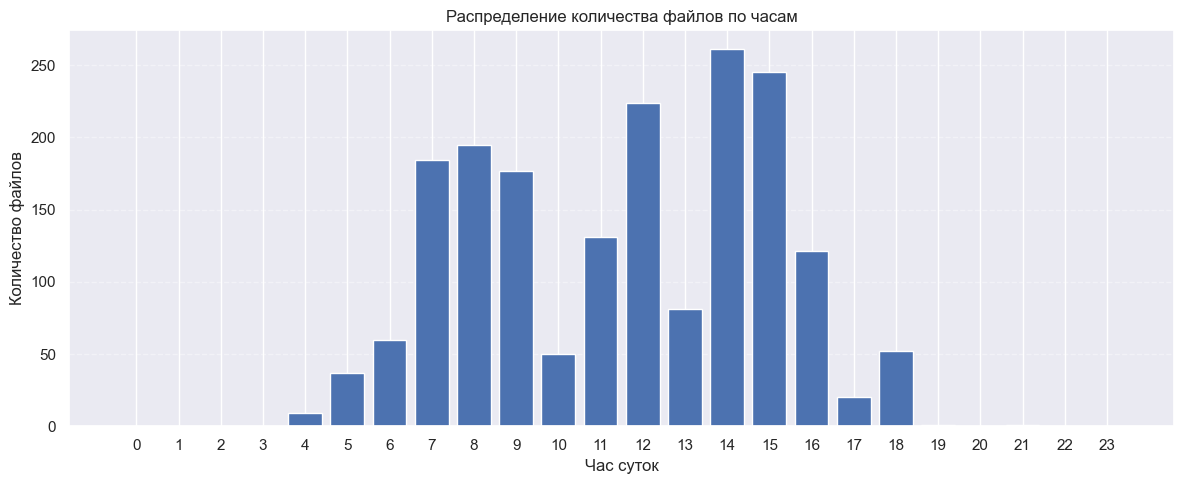

In [202]:
# size считает количество строк в каждой группе (типа как count, только без повт значений)

by_dow_counts  = df.groupby("dow").size().reindex(range(7), fill_value=0)
by_hour_counts = df.groupby("hour").size().reindex(range(24), fill_value=0)

dow_labels = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]

plt.figure(figsize=(12, 5))
plt.bar(range(7), by_dow_counts.values)
plt.title("Распределение количества файлов по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество файлов")
plt.xticks(ticks=range(7), labels=dow_labels)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

plt.figure(figsize=(12, 5))
plt.bar(range(24), by_hour_counts.values)
plt.title("Распределение количества файлов по часам")
plt.xlabel("Час суток")
plt.ylabel("Количество файлов")
plt.xticks(ticks=range(0, 24, 1))
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()


/var/folders/cr/kkk6yb8j5ml02kjf2pmnw19w0000gn/T/ipykernel_5823/3310513276.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(dow_labels)


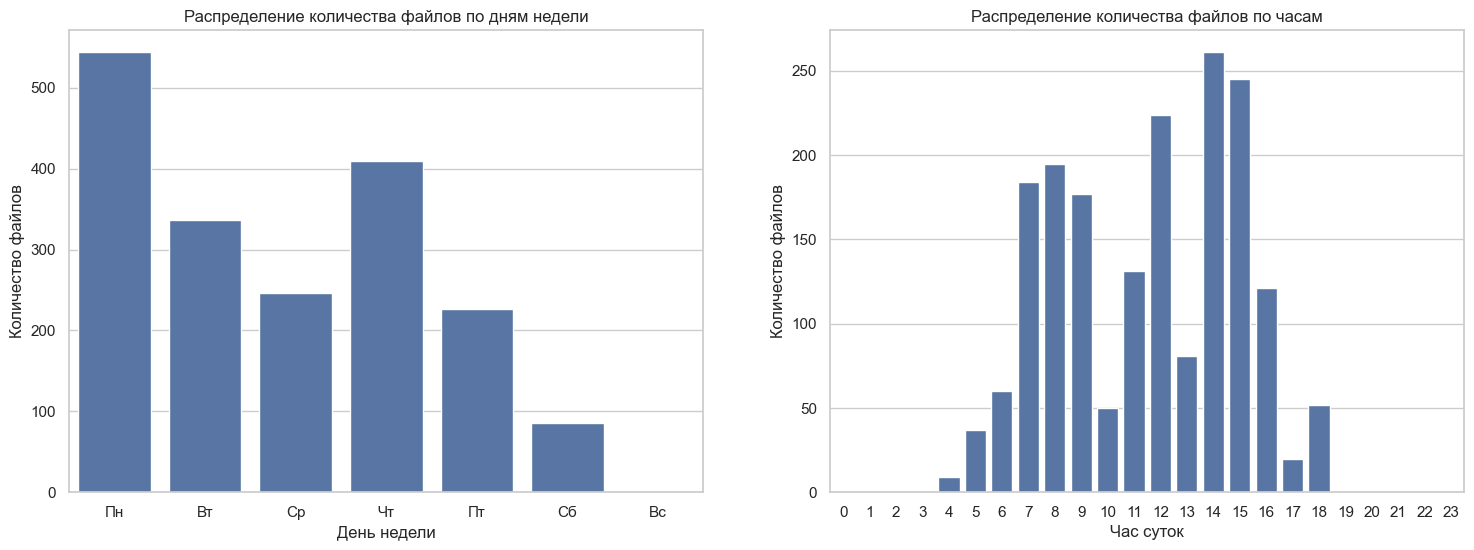

In [210]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

dow_order  = [0, 1, 2, 3, 4, 5, 6]
dow_labels = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
sns.countplot(data=df, x="dow", order=dow_order, ax=axes[0])
axes[0].set_xticklabels(dow_labels)
axes[0].set_title("Распределение количества файлов по дням недели")
axes[0].set_xlabel("День недели")
axes[0].set_ylabel("Количество файлов")

hour_order = list(range(24))
sns.countplot(data=df, x="hour", order=hour_order, ax=axes[1])
axes[1].set_title("Распределение количества файлов по часам")
axes[1].set_xlabel("Час суток")
axes[1].set_ylabel("Количество файлов")

plt.show()

/var/folders/cr/kkk6yb8j5ml02kjf2pmnw19w0000gn/T/ipykernel_5823/3655737756.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


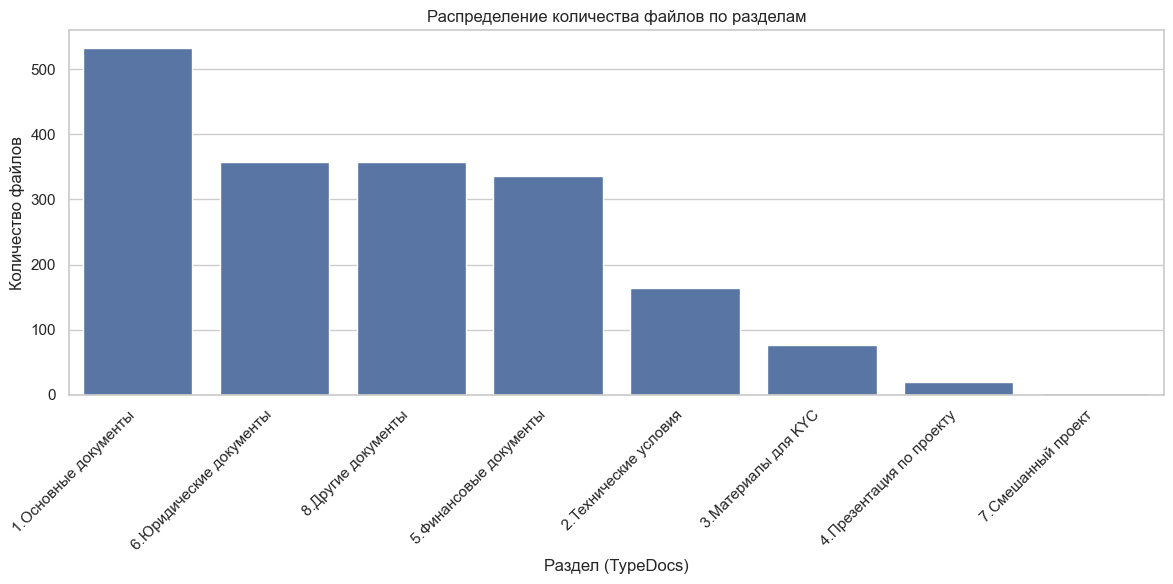

/var/folders/cr/kkk6yb8j5ml02kjf2pmnw19w0000gn/T/ipykernel_5823/3655737756.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")


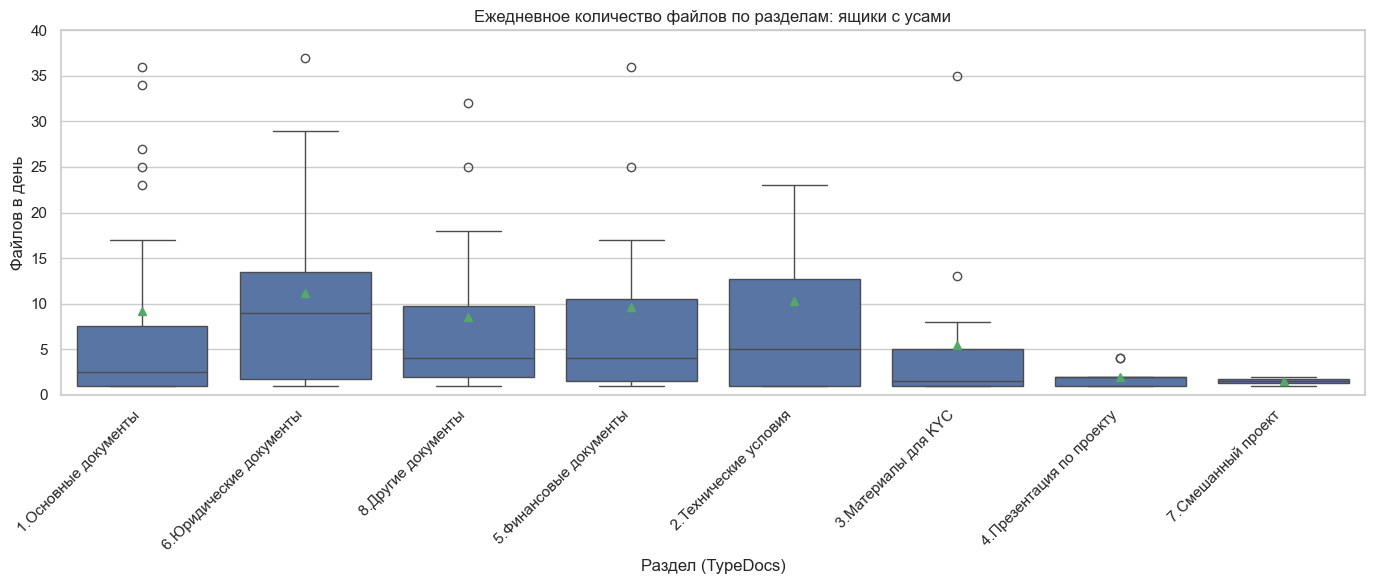

In [214]:
sns.set_theme(style="whitegrid")
order_sections = df["TypeDocs"].value_counts().index

plt.figure(figsize=(max(12, 0.6*len(order_sections)), 6))
ax1 = sns.countplot(data=df, x="TypeDocs", order=order_sections)
ax1.set_title("Распределение количества файлов по разделам")
ax1.set_xlabel("Раздел (TypeDocs)")
ax1.set_ylabel("Количество файлов")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

daily = (df.groupby(["TypeDocs", "date"])
           .size()
           .reset_index(name="files_per_day"))

plt.figure(figsize=(max(14, 0.6*len(order_sections)), 6))
ax2 = sns.boxplot(data=daily, x="TypeDocs", y="files_per_day", order=order_sections, showmeans=True)
ax2.set_title("Ежедневное количество файлов по разделам: ящики с усами")
ax2.set_xlabel("Раздел (TypeDocs)")
ax2.set_ylabel("Файлов в день")
ax2.set_ylim(0, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

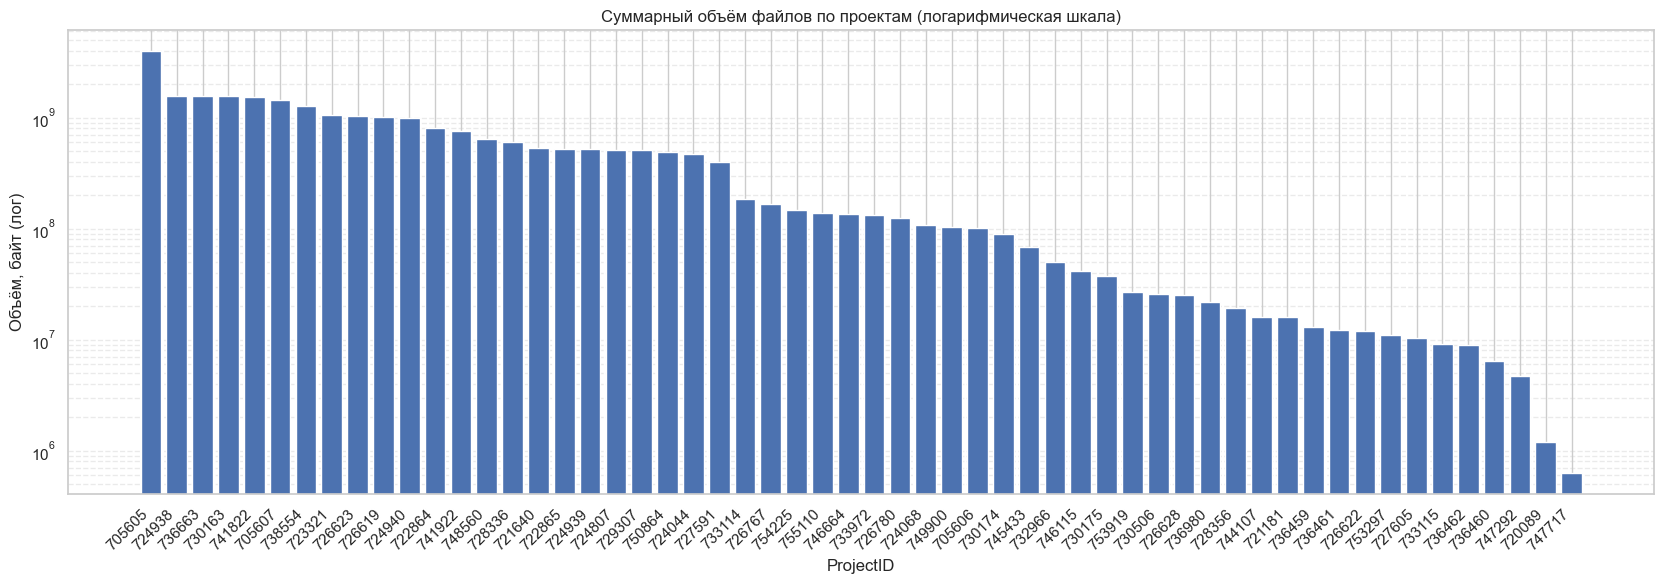

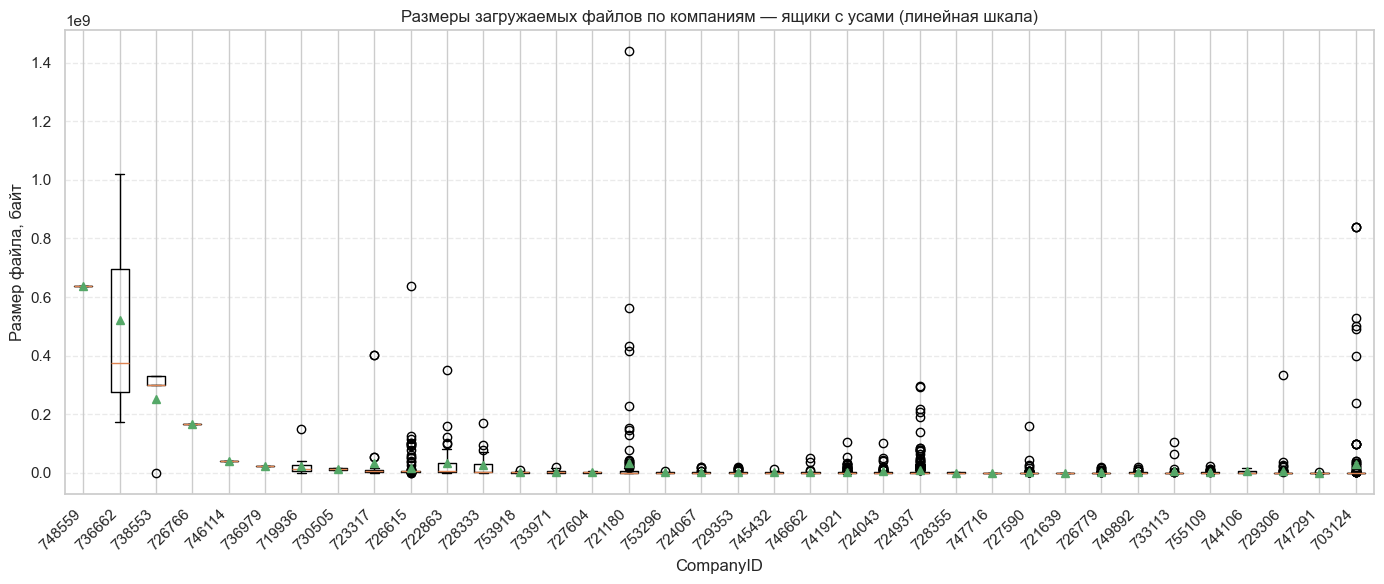

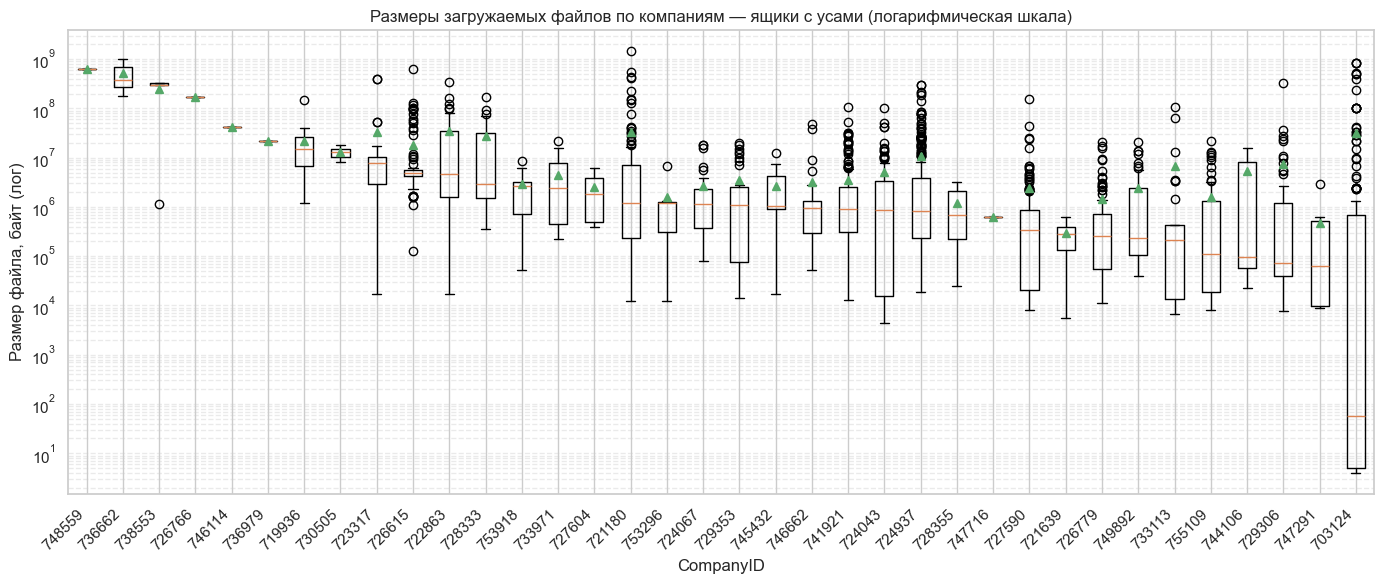

In [223]:
# ---------------------------------------------------------
# ЗАДАНИЕ 4: Гистограмма суммарного объёма файлов по проектам (лог-ось Y)
# ---------------------------------------------------------
by_project = (
    df.groupby("ProjectID", as_index=False)["FileSize"]
            .sum()
            .rename(columns={"FileSize": "bytes_total"})
            .sort_values("bytes_total", ascending=False)
)

# Настройка размера полотна пропорционально числу проектов
n_projects = len(by_project)
fig_w = max(12, 0.3 * n_projects)

plt.figure(figsize=(fig_w, 6))
plt.bar(by_project["ProjectID"].astype(str), by_project["bytes_total"].values)
plt.yscale("log")
plt.title("Суммарный объём файлов по проектам (логарифмическая шкала)")
plt.xlabel("ProjectID")
plt.ylabel("Объём, байт (лог)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", which="both", linestyle="--", alpha=0.4)
plt.tight_layout()

# ---------------------------------------------------------
# ЗАДАНИЕ 5: Ящики с усами размеров файлов по компаниям
# ---------------------------------------------------------
# Порядок компаний по медиане размера файла (от большего к меньшему)
medians = df.groupby("CompanyID")["FileSize"].median().sort_values(ascending=False)
companies_order = medians.index.tolist()

# Данные для boxplot в этом порядке
box_data = [df.loc[df["CompanyID"] == cid, "FileSize"].values for cid in companies_order]

n_companies = len(companies_order)
fig_w2 = max(14, 0.35 * n_companies)

# Вариант 1: линейная шкала
plt.figure(figsize=(fig_w2, 6))
plt.boxplot(box_data, labels=[str(c) for c in companies_order], showmeans=True)
plt.title("Размеры загружаемых файлов по компаниям — ящики с усами (линейная шкала)")
plt.xlabel("CompanyID")
plt.ylabel("Размер файла, байт")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

# Вариант 2: логарифмическая шкала (часто удобнее из-за «тяжёлых хвостов» размеров)
plt.figure(figsize=(fig_w2, 6))
plt.boxplot(box_data, labels=[str(c) for c in companies_order], showmeans=True)
plt.yscale("log")
plt.title("Размеры загружаемых файлов по компаниям — ящики с усами (логарифмическая шкала)")
plt.xlabel("CompanyID")
plt.ylabel("Размер файла, байт (лог)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", which="both", linestyle="--", alpha=0.4)
plt.tight_layout()